Get statistics about the dataset

In [2]:
import sparqlqueries as sq
import pandas as pd
import matplotlib.pyplot as plt
import paths as p
import json

In [3]:
melart_annotations=json.load(open(p.MELART_ANNOTATIONS_PATH, 'r'))

In [4]:
artworks_qids=dict() # split -> list of qids (keys from the melart annotations)
for qid,melart_artwork in melart_annotations.items():
    split=melart_artwork['split']
    if split not in artworks_qids:
        artworks_qids[split]=[]
    artworks_qids[split].append(qid)
print([f"Split {split}: {len(qids)} artworks" for split,qids in artworks_qids.items()])

['Split test: 100 artworks', 'Split train: 1188 artworks', 'Split val: 328 artworks']


In [5]:
all_qids=[qid for split,qids in artworks_qids.items() for qid in qids]
print(f"Total: {len(all_qids)} artworks")

Total: 1616 artworks


In [6]:
sparql_movements="""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT ?ent ?movement  WHERE{ 
VALUES ?ent { %s }
 ?ent wdt:P135 ?movement.
}
""" % " ".join([f"wd:{qid}" for qid in all_qids])
df_movement=sq.sparql_pandas_query(sparql_movements)
df_movement['ent']=df_movement['ent'].apply(lambda x: x.split('/')[-1])
df_movement['movement']=df_movement['movement'].apply(lambda x: x.split('/')[-1])
print(len(df_movement))
df_movement.head()

869


,ent,movement
0,Q1000128,Q189458
1,Q1025704,Q166713
2,Q102852946,Q6076361
3,Q10468599,Q166713
4,Q1065493,Q184814


In [7]:
set_movements=set(df_movement['movement'])
print(f"Total of {len(set_movements)} movements")

Total of 82 movements


Query the labels of the movements

In [8]:
movement_labels=sq.sparql_all_lables(list(set_movements))
for movement in list(set_movements)[:10]:
    print(f"{movement} -> {movement_labels[movement][0]}")

Q443153 -> Early Netherlandish painting
Q150091 -> neo-impressionism
Q610687 -> Venetian school
Q2642826 -> Realism
Q166593 -> fauvism
Q943853 -> Hudson River school
Q34636 -> Art Nouveau
Q2316866 -> geometric abstraction
Q3032335 -> Heidelberg School
Q2914470 -> Italian Renaissance painting


Count the number of artworks per movement

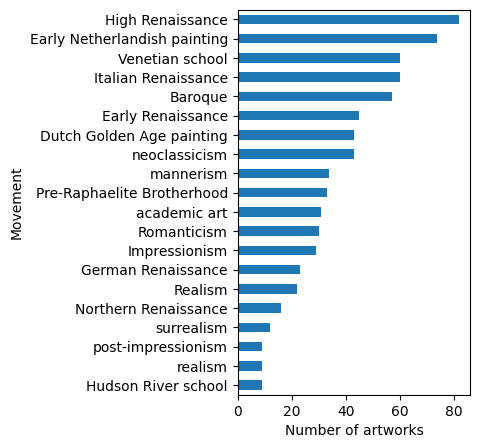

In [47]:
df_movements_count=df_movement.groupby('movement').size().reset_index(name='count')
df_movements_count=df_movements_count.sort_values('count', ascending=False)
df_movements_count["label"]=df_movements_count["movement"].apply(lambda x: movement_labels[x][0])
k=20
ax=df_movements_count.head(k).plot(kind='barh', x='label', xlabel='Number of artworks' ,ylabel='Movement' ,y='count', figsize=(3,5), legend=False)
ax.invert_yaxis()
plt.savefig("figures/movements.pdf", bbox_inches='tight', format='pdf')

High Renaissance is the most represented movement, but all 4 most represented movements are from the Renaissance period.

In [10]:
unknown_movement_artworks=set(all_qids)-set(df_movement["ent"])
print(f"Total of {len(unknown_movement_artworks)} artworks without movement")

Total of 861 artworks without movement


In [11]:
sparql_genres="""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT ?ent ?genre  WHERE{ 
VALUES ?ent { %s }
 ?ent wdt:P136 ?genre.
}
""" % " ".join([f"wd:{qid}" for qid in all_qids])
df_genre=sq.sparql_pandas_query(sparql_genres)
df_genre['ent']=df_genre['ent'].apply(lambda x: x.split('/')[-1])
df_genre['genre']=df_genre['genre'].apply(lambda x: x.split('/')[-1])
print(len(df_genre))
df_genre.head()

1690


,ent,genre
0,Q1000128,Q1047337
1,Q1016012,Q19547247
2,Q1025704,Q1935974
3,Q102852946,Q2864737
4,Q10322725,Q134307


In [12]:
set_genres=set(df_genre['genre'])
print(f"Total of {len(set_genres)} genres")

Total of 63 genres


In [13]:
genre_labels=sq.sparql_all_lables(list(set_genres))
for genre in list(set_genres)[:10]:
    print(f"{genre} -> {genre_labels[genre][0]}")

Q2278308 -> capriccio
Q3374353 -> battle painting
Q18811686 -> interior view
Q10857409 -> realism
Q166030 -> Veduta
Q37068 -> Romanticism
Q2415378 -> schutterstuk
Q3304751 -> meisho-e
Q2302151 -> animal painting
Q40446 -> nude


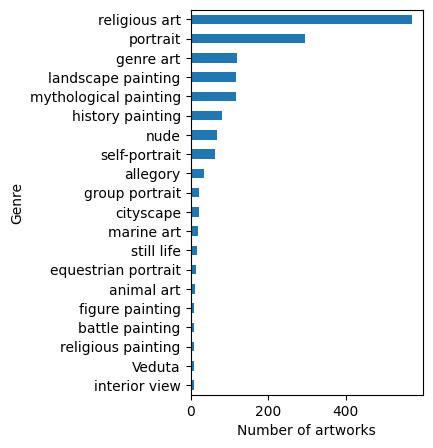

In [46]:
df_genres_count=df_genre.groupby('genre').size().reset_index(name='count')
df_genres_count=df_genres_count.sort_values('count', ascending=False)
df_genres_count["label"]=df_genres_count["genre"].apply(lambda x: genre_labels[x][0])
k=20
ax=df_genres_count.head(k).plot(kind='barh', x='label', xlabel='Number of artworks' , ylabel='Genre' ,y='count', figsize=(3,5), legend=False)
ax.invert_yaxis()
plt.savefig("figures/genres.pdf", bbox_inches='tight', format='pdf')

In [15]:
df_genres_count.head(k)

,genre,count,label
41,Q2864737,571,religious art
12,Q134307,295,portrait
0,Q1047337,121,genre art
25,Q191163,117,landscape painting
47,Q3374376,116,mythological painting
61,Q742333,81,history painting
54,Q40446,68,nude
26,Q192110,62,self-portrait
40,Q2839016,36,allegory
14,Q1551015,23,group portrait


In [16]:
unknown_genre_artworks=set(all_qids)-set(df_genre["ent"])
print(f"Total of {len(unknown_genre_artworks)} artworks without genre")

Total of 129 artworks without genre


In [17]:
sparql_creators="""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT ?ent ?creator  WHERE{
VALUES ?ent { %s }
 ?ent wdt:P170 ?creator.
}
""" % " ".join([f"wd:{qid}" for qid in all_qids])
df_creator=sq.sparql_pandas_query(sparql_creators)
df_creator['ent']=df_creator['ent'].apply(lambda x: x.split('/')[-1])
df_creator['creator']=df_creator['creator'].apply(lambda x: x.split('/')[-1])
print(len(df_creator))
df_creator.head()

1649


,ent,creator
0,Q1000128,Q483992
1,Q1016012,Q46373
2,Q1025704,Q5582
3,Q102852946,Q42207
4,Q10322725,Q64633


In [18]:
set_creators=set(df_creator['creator'])
print(f"Total of {len(set_creators)} creators")

Total of 468 creators


In [19]:
creator_labels=sq.sparql_all_lables(list(set_creators))
for creator in list(set_creators)[:10]:
    print(f"{creator} -> {creator_labels[creator][0]}")

Q269445 -> Catarina van Hemessen
Q5589 -> Henri Matisse
Q463962 -> Henry Scott Tuke
Q3188333 -> Jules-Claude Ziegler
Q211763 -> William Holman Hunt
Q965809 -> Frederick McCubbin
Q312393 -> Gentile da Fabriano
Q553258 -> Francisco Pradilla y Ortiz
Q212754 -> John William Waterhouse
Q271676 -> Charles Le Brun


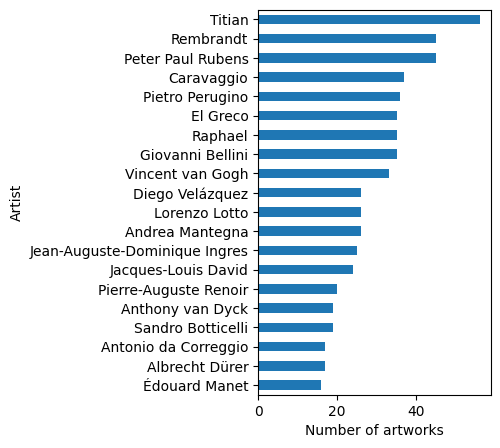

In [44]:
df_creators_count=df_creator.groupby('creator').size().reset_index(name='count')
df_creators_count=df_creators_count.sort_values('count', ascending=False)
df_creators_count["label"]=df_creators_count["creator"].apply(lambda x: creator_labels[x][0])
k=20
ax=df_creators_count.head(k).plot(kind='barh', x='label', ylabel='Artist' ,y='count', figsize=(3,5), xlabel='Number of artworks', legend=False)
ax.invert_yaxis()
plt.savefig("figures/creators.pdf", bbox_inches='tight', format='pdf')

In [21]:
unknown_creator_artworks=set(all_qids)-set(df_creator["ent"])
print(f"Total of {len(unknown_creator_artworks)} artworks without creator")

Total of 1 artworks without creator


In [22]:
sparql_dates="""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT ?ent ?date  WHERE{
VALUES ?ent { %s }
 ?ent wdt:P571 ?date.
}
""" % " ".join([f"wd:{qid}" for qid in all_qids])
df_date=sq.sparql_pandas_query(sparql_dates)
df_date['ent']=df_date['ent'].apply(lambda x: x.split('/')[-1])
#parse the dates
df_date['year']=df_date['date'].apply(lambda x: x.split('-')[0] if '-' in x else x)
df_date['year']=pd.to_numeric(df_date['year'], errors='coerce')
df_date.head()

,ent,date,year
0,Q1000128,1890-01-01T00:00:00Z,1890.0
1,Q1016012,1871-01-01T00:00:00Z,1871.0
2,Q1025704,1888-09-01T00:00:00Z,1888.0
3,Q102852946,1700-01-01T00:00:00Z,1700.0
4,Q10322725,1869-01-01T00:00:00Z,1869.0


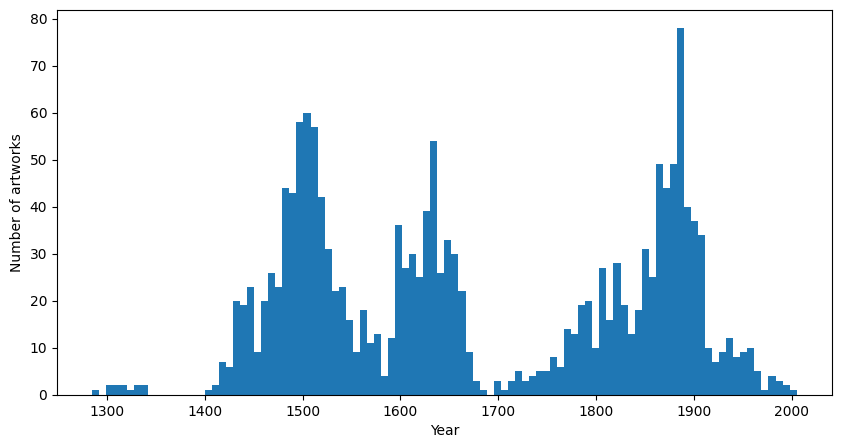

In [23]:
df_date['year'].plot(kind='hist', bins=100, figsize=(10,5))
plt.xlabel('Year')
plt.ylabel('Number of artworks')
plt.savefig("figures/dates.pdf", bbox_inches='tight', format='pdf')

In [24]:
unknown_date=df_date[df_date['year'].isna()]
print(f"Total of {len(unknown_date)} artworks without date")

Total of 2 artworks without date


In [25]:
sparql_creator_gender="""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT ?gender (COUNT(DISTINCT ?artist) as ?cant) WHERE{ 
    VALUES ?ent { %s }
    ?ent wdt:P170 ?artist.
    OPTIONAL {?artist wdt:P21 ?gender.}
}
GROUP BY ?gender
""" % " ".join([f"wd:{qid}" for qid in all_qids])
df_genders=sq.sparql_pandas_query(sparql_creator_gender)
df_genders.head()

,gender,cant
0,NaN,28
1,http://www.wikidata.org/entity/Q12964198,1
2,http://www.wikidata.org/entity/Q48270,1
3,http://www.wikidata.org/entity/Q6581072,27
4,http://www.wikidata.org/entity/Q6581097,413


In [27]:
df_genders['gender']=df_genders['gender'].apply(lambda x: x.split('/')[-1] if (isinstance(x,str) and x.startswith('http')) else "Unknown")
gender_labels=sq.sparql_all_lables(list(df_genders['gender']))
gender_labels["Unknown"]=["Unknown"]
df_genders["label"]=df_genders["gender"].apply(lambda x: gender_labels.get(x, ["Unknown"])[0])
df_genders.head()

,gender,cant,label
0,Unknown,28,Unknown
1,Q12964198,1,genderqueer
2,Q48270,1,non-binary
3,Q6581072,27,female
4,Q6581097,413,male


In [37]:
sparql_creator_nationality="""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT ?country
(COUNT(DISTINCT ?ent) as ?cant_paintings) (COUNT(DISTINCT ?artist) as ?cant_artists) WHERE{ 
    VALUES ?ent { %s }
    ?ent wdt:P170 ?artist.
    OPTIONAL {?artist wdt:P27 ?country.}
}
GROUP BY ?country
ORDER BY DESC(?cant_paintings)
""" % " ".join([f"wd:{qid}" for qid in all_qids])
df_nationalities=sq.sparql_pandas_query(sparql_creator_nationality)
df_nationalities['country']=df_nationalities['country'].apply(lambda x: x.split('/')[-1] if (isinstance(x,str) and x.startswith('http')) else "Unknown")
df_nationalities.head()

,country,cant_paintings,cant_artists
0,Q142,259,73
1,Q4948,217,23
2,Unknown,143,59
3,Q170072,107,27
4,Q30,103,49


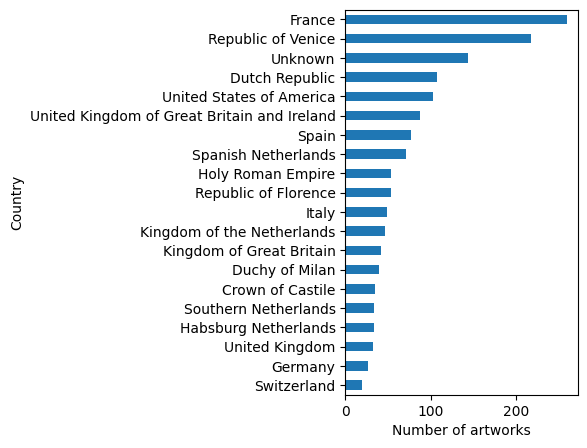

In [45]:

country_labels=sq.sparql_all_lables(list(df_nationalities['country']))
country_labels["Unknown"]=["Unknown"]
df_nationalities["label"]=df_nationalities["country"].apply(lambda x: country_labels.get(x, ["Unknown"])[0])
k=20
ax=df_nationalities.head(k).plot(kind='barh', x='label', ylabel='Country' ,y='cant_paintings', figsize=(3,5), xlabel='Number of artworks', legend=False)
ax.invert_yaxis()
plt.savefig("figures/nationalities.pdf", bbox_inches='tight', format='pdf')

<Axes: title={'center': 'Number of artists per nationality'}, xlabel='Country'>

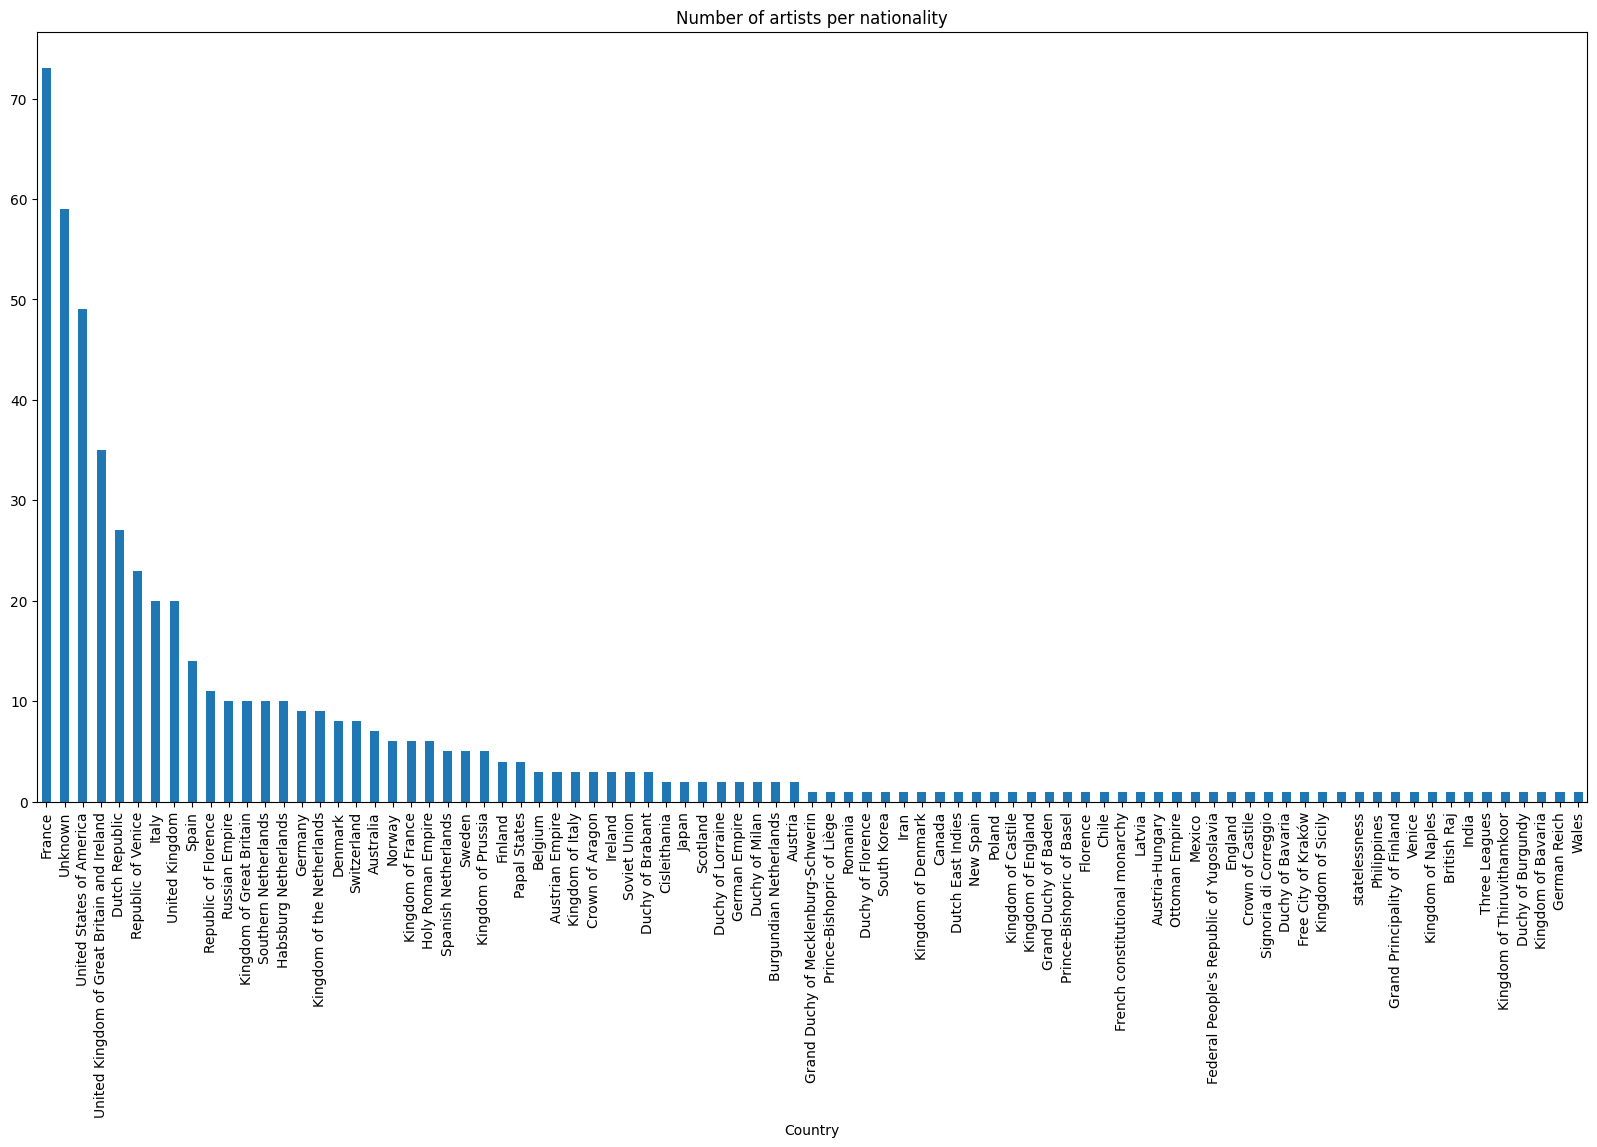

In [30]:
df_nationalities.sort_values('cant_artists', ascending=False).plot(kind='bar', x='label', xlabel='Country' ,y='cant_artists', figsize=(20,10), title='Number of artists per nationality', legend=False)

In [31]:
df_movements_creators=df_movement.merge(df_creator, left_on='ent', right_on='ent')
df_movements_creators.head()

,ent,movement,creator
0,Q1000128,Q189458,Q483992
1,Q1025704,Q166713,Q5582
2,Q102852946,Q6076361,Q42207
3,Q10468599,Q166713,Q1132040
4,Q1065493,Q184814,Q159606


In [32]:
#bar chart with the number of artworks per movement and creator, creators are bars and movements are stacked
df_movements_creators_count=df_movements_creators.groupby(['movement','creator']).size().reset_index(name='count')
df_movements_creators_count=df_movements_creators_count.sort_values('count', ascending=False)
df_movements_creators_count["label_creator"]=df_movements_creators_count["creator"].apply(lambda x: creator_labels.get(x, ["Unknown"])[0])
df_movements_creators_count["label_movement"]=df_movements_creators_count["movement"].apply(lambda x: movement_labels.get(x, ["Unknown"])[0])
df_movements_creators_count=df_movements_creators_count[df_movements_creators_count["label_creator"]!="Unknown"]
df_movements_creators_count=df_movements_creators_count[df_movements_creators_count["label_movement"]!="Unknown"]
df_movements_creators_count.head(50)

,movement,creator,count,label_creator,label_movement
264,Q610687,Q47551,52,Titian,Venetian school
131,Q2352880,Q5598,36,Rembrandt,Dutch Golden Age painting
37,Q1404472,Q5827,33,Pietro Perugino,Italian Renaissance
74,Q1474884,Q5597,33,Raphael,High Renaissance
195,Q37853,Q42207,27,Caravaggio,Baroque
71,Q1474884,Q47551,23,Titian,High Renaissance
43,Q14378,Q23380,20,Jean-Auguste-Dominique Ingres,neoclassicism
61,Q1472236,Q5669,19,Sandro Botticelli,Early Renaissance
50,Q14378,Q83155,18,Jacques-Louis David,neoclassicism
134,Q2455000,Q5580,17,Albrecht Dürer,German Renaissance
